In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

path = 'Salary_Data.csv'

df = pd.read_csv(path)
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


# Data Cleaning

In [2]:
df['Education Level'].value_counts()

Education Level
Bachelor's Degree    2267
Master's Degree      1573
PhD                  1368
Bachelor's            756
High School           448
Master's              288
phD                     1
Name: count, dtype: int64

In [3]:
print(df.columns)
print(type(df.Salary[0]))
print(type(df['Years of Experience'][0]))

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object')
<class 'numpy.float64'>
<class 'numpy.float64'>


In [4]:
# Combining the education level Bachelor's degree and Bachelor's
df['Education Level'] = df['Education Level'].replace("Bachelor's Degree", "Bachelor's")
df['Education Level'] = df['Education Level'].replace("phD", "PhD")
df['Education Level'] = df['Education Level'].replace("Master's Degree", "Master's")

df['Education Level'].value_counts()

Education Level
Bachelor's     3023
Master's       1861
PhD            1369
High School     448
Name: count, dtype: int64

Text(0, 0.5, 'Salary')

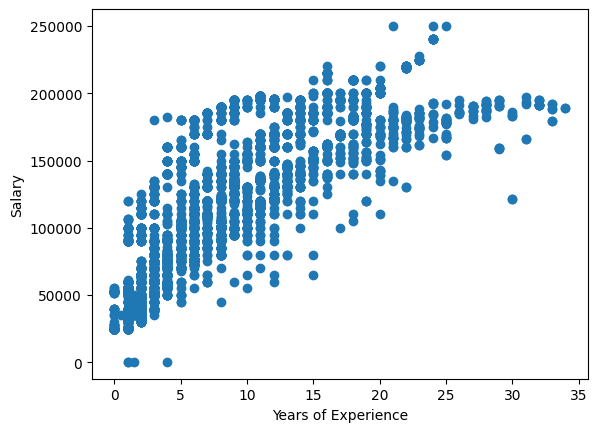

In [5]:
plt.scatter(df['Years of Experience'], df['Salary'])
plt.xlabel('Years of Experience')
plt.ylabel('Salary')

C:\Users\carlo\AppData\Local\Temp\ipykernel_8148\2615817528.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Education Level')['Salary'].mean().plot(kind='bar')


<Axes: xlabel='Education Level'>

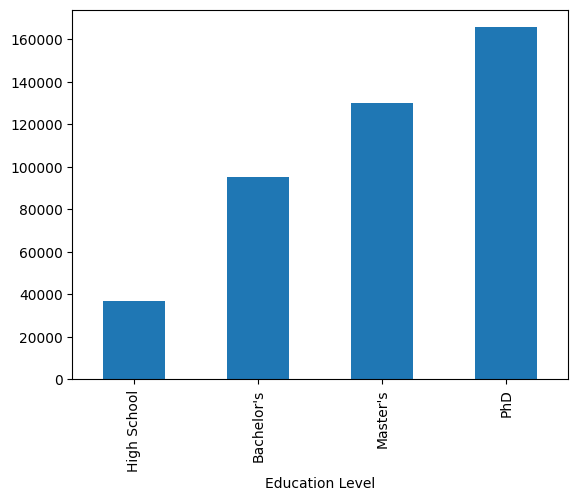

In [6]:
df['Education Level'] = pd.Categorical(df['Education Level'], categories=['High School', 'Bachelor\'s', 'Master\'s', 'PhD'], ordered=True)

df.groupby('Education Level')['Salary'].mean().plot(kind='bar')

In [7]:
# Job Title with the most data
df['Job Title'].value_counts()

Job Title
Software Engineer             518
Data Scientist                453
Software Engineer Manager     376
Data Analyst                  363
Senior Project Engineer       318
                             ... 
Account Manager                 1
Help Desk Analyst               1
Senior Training Specialist      1
Junior Web Designer             1
Supply Chain Analyst            1
Name: count, Length: 193, dtype: int64

In [8]:
# Remove Jobs with less than 10 data points
df = df.groupby('Job Title').filter(lambda x: len(x) > 100)
df['Job Title'].value_counts()

Job Title
Software Engineer            518
Data Scientist               453
Software Engineer Manager    376
Data Analyst                 363
Senior Project Engineer      318
Product Manager              313
Full Stack Engineer          309
Marketing Manager            255
Senior Software Engineer     244
Back end Developer           244
Front end Developer          241
Marketing Coordinator        158
Junior Sales Associate       142
Financial Manager            134
Marketing Analyst            132
Software Developer           125
Operations Manager           114
Human Resources Manager      104
Name: count, dtype: int64

# Define Model

In [9]:
import torch.nn as nn
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        # self.activation2 = nn.ReLU()
        # self.layer3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        # x = self.activation2(x)
        # return self.layer3(x)
        return x

# Prepare data

In [57]:
import joblib
# Encode 'Education Level' for simplicity
education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df['Education Level'] = df['Education Level'].map(lambda x: education_mapping.get(x, x)).copy()

df = df[df['Gender'] != 'Other']
gender_mapping = {'Male': 0, 'Female': 1}
df['Gender'] = df['Gender'].map(lambda x: gender_mapping.get(x, x)).copy()

train, test = train_test_split(df, test_size=0.3, random_state=42)
train, val = train_test_split(train, test_size=0.11, random_state=42)

target_column = "Salary"
sensitive_feature = ['Age', 'Gender']
features = train.columns.difference([target_column])

scaler = StandardScaler()

train[['Years of Experience', 'Salary', 'Age']] = scaler.fit_transform(train[['Years of Experience', 'Salary', 'Age']])
val[['Years of Experience', 'Salary', 'Age']] = scaler.transform(val[['Years of Experience', 'Salary', 'Age']])
test[['Years of Experience', 'Salary', 'Age']] = scaler.transform(test[['Years of Experience', 'Salary', 'Age']])

joblib.dump(scaler, "scaler_preds")

encoder = LabelEncoder()
train['Job Title'] = encoder.fit_transform(train['Job Title'])
val['Job Title'] = encoder.transform(val['Job Title'])
test['Job Title'] = encoder.transform(test['Job Title'])

X_train = pd.DataFrame((train),columns = features)
y_train = pd.DataFrame((train),columns = [target_column])
# X_train = torch.tensor(train[features].values, dtype=torch.float32)
# y_train = torch.tensor(train[target_column].values, dtype=torch.float32).view(-1, 1)
X_val = pd.DataFrame((val),columns = features)
y_val = pd.DataFrame((val),columns = [target_column])
# X_val = torch.tensor(val[features].values, dtype=torch.float32)
# y_val = torch.tensor(val[target_column].values, dtype=torch.float32).view(-1, 1)
X_test = pd.DataFrame((test),columns = features)
y_test = pd.DataFrame((test),columns = [target_column])
# X_test = torch.tensor(test[features].values, dtype=torch.float32)
# y_test = torch.tensor(test[target_column].values, dtype=torch.float32).view(-1, 1)

In [11]:
#fill na values with 0 
y_train = y_train.fillna(0)


In [12]:
X_train

,Age,Education Level,Gender,Job Title,Years of Experience
3839,0.648389,2,1,6,0.408237
4032,1.161282,3,0,2,1.219705
2910,1.545952,2,0,14,1.868880
2364,-1.274961,1,1,15,-1.052406
5138,0.391942,1,0,12,0.570530
...,...,...,...,...,...
2414,-1.403184,3,0,17,-1.214700
846,-1.018514,1,0,1,-0.890113
1717,0.648389,2,1,14,0.408237
4015,-0.890291,2,1,10,-0.890113


In [13]:
y_train.isna().sum()

Salary    0
dtype: int64

# Training For Data Scientist Job not important for prediction

In [14]:
selected_features = ['Years of Experience', 'Education Level']
model_all = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000)
model_all.fit(X_train[selected_features], y_train)

y_pred = model_all.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Inverse transform predictions back to original salary scale
y_test_pred_unscaled = scaler.inverse_transform(
    np.concatenate((X_test[['Years of Experience']].values, y_pred.reshape(-1, 1), X_test[['Age']].values), axis=1))[:, 1]

sum_error_all = 0

for i, pred in enumerate(y_test_pred_unscaled):
    actual_salary = scaler.inverse_transform(test[['Years of Experience', 'Salary', 'Age']].values)[i][1]
    sum_error_all += abs(pred - actual_salary)/ len(y_test_pred_unscaled)
    
print(f"Average Error: {sum_error_all}")

C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 0.2745255139268479
Average Error: 19819.622439997976


In [15]:
# Set up model parameters
selected_features = ['Years of Experience', 'Education Level']

input_dim = 2  # Years of Experience, Education Level, 
hidden_dim = 64
output_dim = 1
model_all = RegressionModel(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_all.parameters(), lr=0.001, weight_decay=1e-4)  # Add weight decay for L2 regularization

# Training loop
train_losses, val_losses = [], []
for epoch in range(5000):
    model_all.train()
    optimizer.zero_grad()
    y_pred = model_all(X_train[selected_features])
    train_loss = criterion(y_pred, y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    # Validation loss
    model_all.eval()
    with torch.no_grad():
        y_val_pred = model_all(X_val[selected_features])
        val_loss = criterion(y_val_pred, y_val)
        val_losses.append(val_loss.item())
        
    # Print progress every 100 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch} - Train Loss: {train_loss.item()} | Validation Loss: {val_loss.item()}')

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
model_all.eval()
with torch.no_grad():
    y_test_pred = model_all(X_test[selected_features])
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item()}')

TypeError: linear(): argument 'input' (position 1) must be Tensor, not DataFrame

# Including Gender & Age

           Age  Gender Education Level          Job Title  \
403   0.969242       1               1  Software Engineer   
918   1.335123       0               1  Software Engineer   
938   1.335123       0               1  Software Engineer   
712   1.335123       0               1  Software Engineer   
4041  0.237481       0               1  Software Engineer   

      Years of Experience    Salary  
403              0.688693  0.901876  
918              1.573959  1.631115  
938              1.573959  1.631115  
712              1.573959  1.631115  
4041            -0.196573 -0.869134  
Epoch 0 - Train Loss: 0.8456382155418396 | Validation Loss: 0.9417287111282349
Epoch 1000 - Train Loss: 0.14354194700717926 | Validation Loss: 0.1264873445034027
Epoch 2000 - Train Loss: 0.10309251397848129 | Validation Loss: 0.10133866965770721
Epoch 3000 - Train Loss: 0.06857627630233765 | Validation Loss: 0.07777152955532074
Epoch 4000 - Train Loss: 0.054800186306238174 | Validation Loss: 0.06756573

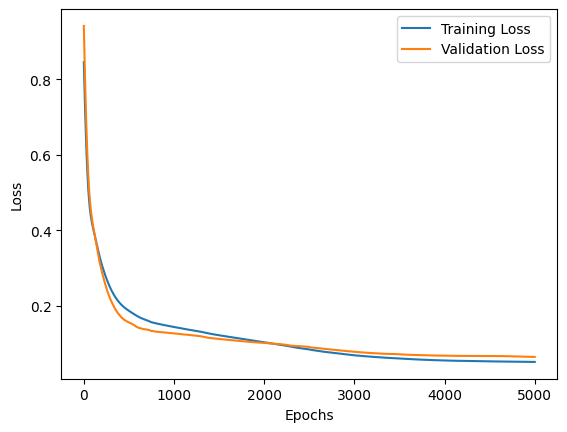

Test Loss: 0.08697637170553207


ValueError: operands could not be broadcast together with shapes (156,3) (2,) (156,3) 

In [55]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Drop rows with missing values in the relevant columns
df_drop2 = df.dropna(subset=['Salary', 'Years of Experience', 'Education Level', 'Gender', 'Age']).copy()

# Check for NaN or infinite values
train = train.fillna(0)
assert not train.isnull().values.any(), "Training data contains NaN values"

assert not val.isnull().values.any(), "Validation data contains NaN values"
assert not test.isnull().values.any(), "Test data contains NaN values"
assert np.isfinite(train[['Years of Experience', 'Salary', 'Age']].values).all(), "Training data contains infinite values"
assert np.isfinite(val[['Years of Experience', 'Salary', 'Age']].values).all(), "Validation data contains infinite values"
assert np.isfinite(test[['Years of Experience', 'Salary', 'Age']].values).all(), "Test data contains infinite values"


# Set up model parameters
input_dim = 4  # Years of Experience, Education Level, Gender, Age
hidden_dim = 20
output_dim = 1
model_all_gen_age = RegressionModel(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_all_gen_age.parameters(), lr=0.001, weight_decay=1e-4)  # Add weight decay for L2 regularization

# Prepare data for PyTorch
print(train.head())
X_train = torch.tensor(train[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)
y_train = torch.tensor(train['Salary'].values, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(val[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)
y_val = torch.tensor(val['Salary'].values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(test[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)
y_test = torch.tensor(test['Salary'].values, dtype=torch.float32).view(-1, 1)

# Training loop
train_losses, val_losses = [], []
for epoch in range(5000):
    model_all_gen_age.train()
    optimizer.zero_grad()
    y_pred = model_all_gen_age(X_train)
    train_loss = criterion(y_pred, y_train)
    if torch.isnan(train_loss):
        print(f"NaN detected in train loss at epoch {epoch}")
        break
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

    # Validation loss
    model_all_gen_age.eval()
    with torch.no_grad():
        y_val_pred = model_all_gen_age(X_val)
        val_loss = criterion(y_val_pred, y_val)
        if torch.isnan(val_loss):
            print(f"NaN detected in validation loss at epoch {epoch}")
            break
        val_losses.append(val_loss.item())

    # Print progress every 100 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch} - Train Loss: {train_loss.item()} | Validation Loss: {val_loss.item()}')

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
model_all_gen_age.eval()
with torch.no_grad():
    y_test_pred = model_all_gen_age(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item()}')

# Inverse transform predictions back to original salary scale
# We add placeholders for 'Years of Experience' and 'Age' to inverse transform correctly
y_test_pred_unscaled = scaler.inverse_transform(
    torch.cat((X_test[:, 0].unsqueeze(1), y_test_pred, X_test[:, 1:2]), dim=1))[:, 1]

print(y_test_pred_unscaled)

sum_error_all_ga = 0
for i, pred in enumerate(y_test_pred_unscaled):
    actual_salary = scaler.inverse_transform(test[['Years of Experience', 'Salary', 'Age']].values)[i][1]
    sum_error_all_ga += abs(pred - actual_salary)/ len(y_test_pred_unscaled)

torch.save(model_all_gen_age.state_dict(), "model_all_gen_age.pth")
print(f"Average Error: {sum_error_all_ga}")

Test loss 0.18

# Training For Software Engineer

Epoch 0 - Train Loss: nan | Validation Loss: nan
Epoch 1000 - Train Loss: nan | Validation Loss: nan
Epoch 2000 - Train Loss: nan | Validation Loss: nan
Epoch 3000 - Train Loss: nan | Validation Loss: nan
Epoch 4000 - Train Loss: nan | Validation Loss: nan
Epoch 5000 - Train Loss: nan | Validation Loss: nan
Epoch 6000 - Train Loss: nan | Validation Loss: nan
Epoch 7000 - Train Loss: nan | Validation Loss: nan
Epoch 8000 - Train Loss: nan | Validation Loss: nan
Epoch 9000 - Train Loss: nan | Validation Loss: nan


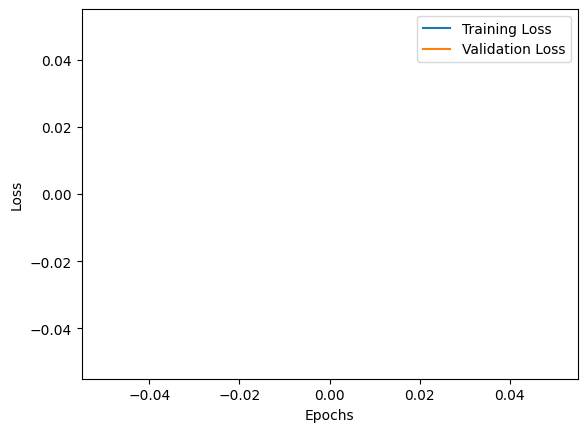

Test Loss: nan
Average Error: nan


In [18]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Filter data for a specific job title
job = 'Software Engineer'
df_job = df[df['Job Title'] == job]
df_job = df_job.dropna(subset=['Salary', 'Years of Experience', 'Education Level']).copy()

# Encode 'Education Level' for simplicity
education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df_job['Education Level'] = df_job['Education Level'].map(education_mapping).copy()

# Split the data
train, test = train_test_split(df_job, test_size=0.3, random_state=42)
train, val = train_test_split(train, test_size=0.11, random_state=42)

# Scale 'Years of Experience' and 'Salary' for stability
scaler = StandardScaler()
train[['Years of Experience', 'Salary']] = scaler.fit_transform(train[['Years of Experience', 'Salary']])
val[['Years of Experience', 'Salary']] = scaler.transform(val[['Years of Experience', 'Salary']])
test[['Years of Experience', 'Salary']] = scaler.transform(test[['Years of Experience', 'Salary']])

# Set up model parameters
input_dim = 2  # Years of Experience, Education Level
hidden_dim = 64
output_dim = 1
model_SE = RegressionModel(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_SE.parameters(), lr=0.0001, weight_decay=1e-4)  # Add weight decay for L2 regularization

# Prepare data for PyTorch
X_train = torch.tensor(train[['Years of Experience', 'Education Level']].values, dtype=torch.float32)
y_train = torch.tensor(train['Salary'].values, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(val[['Years of Experience', 'Education Level']].values, dtype=torch.float32)
y_val = torch.tensor(val['Salary'].values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(test[['Years of Experience', 'Education Level']].values, dtype=torch.float32)
y_test = torch.tensor(test['Salary'].values, dtype=torch.float32).view(-1, 1)

# Training loop
train_losses, val_losses = [], []
for epoch in range(10000):
    model_SE.train()
    optimizer.zero_grad()
    y_pred = model_SE(X_train)
    train_loss = criterion(y_pred, y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    # Validation loss
    model_SE.eval()
    with torch.no_grad():
        y_val_pred = model_SE(X_val)
        val_loss = criterion(y_val_pred, y_val)
        val_losses.append(val_loss.item())
        
    # Print progress every 100 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch} - Train Loss: {train_loss.item()} | Validation Loss: {val_loss.item()}')

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
model_SE.eval()
with torch.no_grad():
    y_test_pred = model_SE(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item()}')

# Inverse transform predictions back to original salary scale
y_test_pred_unscaled = scaler.inverse_transform(
    torch.cat((X_test[:, 0].unsqueeze(1), y_test_pred), dim=1))[:, 1]

sum_error_SE = 0
for i, pred in enumerate(y_test_pred_unscaled):
    actual_salary = scaler.inverse_transform(test[['Years of Experience', 'Salary']].values)[i][1]
    sum_error_SE += abs(pred - actual_salary)/ len(y_test_pred_unscaled)
    
print(f"Average Error: {sum_error_SE}")

# Including Gender & Age

df_job na: Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64
Epoch 0 - Train Loss: 1.3022654056549072 | Validation Loss: 1.4164533615112305
Epoch 1000 - Train Loss: 0.5688026547431946 | Validation Loss: 0.6035553812980652
Epoch 2000 - Train Loss: 0.43631914258003235 | Validation Loss: 0.4519854187965393
Epoch 3000 - Train Loss: 0.32631388306617737 | Validation Loss: 0.32147687673568726
Epoch 4000 - Train Loss: 0.24031050503253937 | Validation Loss: 0.2219475507736206
Epoch 5000 - Train Loss: 0.20394772291183472 | Validation Loss: 0.1840554028749466
Epoch 6000 - Train Loss: 0.18466190993785858 | Validation Loss: 0.16849584877490997
Epoch 7000 - Train Loss: 0.16868896782398224 | Validation Loss: 0.1548292338848114
Epoch 8000 - Train Loss: 0.1536373645067215 | Validation Loss: 0.14050467312335968
Epoch 9000 - Train Loss: 0.14008373022079468 | Validation Loss: 0.1274983584880828

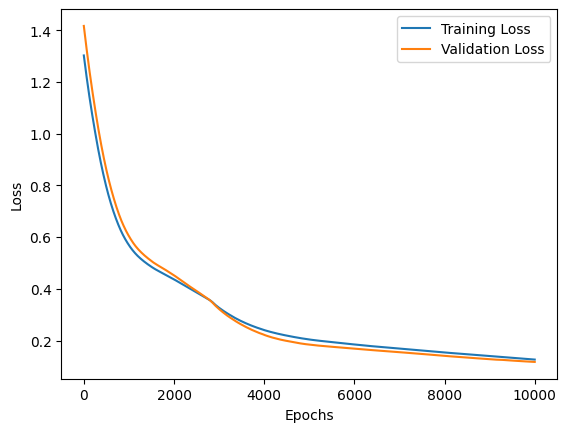

Test Loss: 0.1623462587594986
Average Error: 14103.010071543442


In [75]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Filter data for a specific job title
job = 'Software Engineer'
df_job = df[df['Job Title'] == job]
df_job = df_job[df_job['Gender'] != 'Other']
df_job = df_job.dropna(subset=['Salary', 'Years of Experience', 'Education Level', 'Gender', 'Age']).copy()



# -----------NOT NECESSARY IF ALREADY DONE -------------
# Encode 'Education Level' for simplicity
#education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
#df_job['Education Level'] = df_job['Education Level'].map(education_mapping).copy()

# Encode 'Gender'
##gender_mapping = {'Male': 0, 'Female': 1}
#df_job['Gender'] = df_job['Gender'].map(gender_mapping).copy()

#-----------------------------------
print(f"df_job na: {df_job.isna().sum()}")

# Split the data
train, test = train_test_split(df_job, test_size=0.3, random_state=42)
train, val = train_test_split(train, test_size=0.11, random_state=42)

# Scale 'Years of Experience', 'Age', and 'Salary' for stability
scaler = StandardScaler()
train[['Years of Experience', 'Salary', 'Age']] = scaler.fit_transform(train[['Years of Experience', 'Salary', 'Age']])
val[['Years of Experience', 'Salary', 'Age']] = scaler.transform(val[['Years of Experience', 'Salary', 'Age']])
test[['Years of Experience', 'Salary', 'Age']] = scaler.transform(test[['Years of Experience', 'Salary', 'Age']])

joblib.dump(scaler, "scaler_only_se")

# Set up model parameters
input_dim = 4  # Years of Experience, Education Level, Gender, Age
hidden_dim = 20
output_dim = 1
model_SE_gen_age = RegressionModel(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_SE_gen_age.parameters(), lr=0.0001, weight_decay=1e-4)  # Add weight decay for L2 regularization

# Prepare data for PyTorch
X_train = torch.tensor(train[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)
y_train = torch.tensor(train['Salary'].values, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(val[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)
y_val = torch.tensor(val['Salary'].values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(test[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)
y_test = torch.tensor(test['Salary'].values, dtype=torch.float32).view(-1, 1)



# Training loop
train_losses, val_losses = [], []
for epoch in range(10000):
    model_SE_gen_age.train()
    optimizer.zero_grad()
    y_pred = model_SE_gen_age(X_train)
    train_loss = criterion(y_pred, y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    # Validation loss
    model_SE_gen_age.eval()
    with torch.no_grad():
        y_val_pred = model_SE_gen_age(X_val)
        val_loss = criterion(y_val_pred, y_val)
        val_losses.append(val_loss.item())
        
    # Print progress every 100 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch} - Train Loss: {train_loss.item()} | Validation Loss: {val_loss.item()}')

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
model_SE_gen_age.eval()
with torch.no_grad():
    y_test_pred = model_SE_gen_age(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item()}')

# Inverse transform predictions back to original salary scale
# We add placeholders for 'Years of Experience' and 'Age' to inverse transform correctly
y_test_pred_unscaled = scaler.inverse_transform(
    torch.cat((X_test[:, 0].unsqueeze(1), y_test_pred, X_test[:, 1:2]), dim=1))[:, 1]


sum_error_SE_ga = 0
for i, pred in enumerate(y_test_pred_unscaled):
    actual_salary = scaler.inverse_transform(test[['Years of Experience', 'Salary', 'Age']].values)[i][1]
    sum_error_SE_ga += abs(pred - actual_salary)/ len(y_test_pred_unscaled)


torch.save(model_SE_gen_age.state_dict(), "model_SE_gen_age.pth")    
print(f"Average Error: {sum_error_SE_ga}")

## Define Feature importance ALL JOBS

In [ ]:
df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,0,1,Software Engineer,5.0,90000.0
1,28.0,1,2,Data Analyst,3.0,65000.0
5,29.0,0,1,Marketing Analyst,2.0,55000.0
6,42.0,1,2,Product Manager,12.0,120000.0
8,26.0,1,1,Marketing Coordinator,1.0,45000.0
...,...,...,...,...,...,...
6682,28.0,0,3,Marketing Manager,4.0,55000.0
6690,42.0,0,1,Financial Manager,13.0,130000.0
6691,36.0,1,3,Marketing Manager,9.0,95000.0
6701,30.0,1,1,Financial Manager,4.0,55000.0


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def permutation_importance(model, X, y, n_repeats=10):
    baseline_mse = mean_squared_error(y, model(X).detach().numpy())
    importances = []
    
    for col in range(X.shape[1]):
        feature_importances = []
        for _ in range(n_repeats):
            X_permuted = X.clone()
            X_permuted[:, col] = torch.randperm(X.shape[0])
            permuted_mse = mean_squared_error(y, model(X_permuted).detach().numpy())
            importance = permuted_mse - baseline_mse
            feature_importances.append(importance)
        importances.append(np.mean(feature_importances))
    
    return np.array(importances)

# Calculate permutation importance
feature_names = ['Years of Experience', 'Education Level', 'Gender', 'Age']
importances = permutation_importance(model_all_gen_age, X_test, y_test)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.title('Feature Importance (Permutation Method)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print feature importances
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (156x2 and 4x20)

It's important to note that these values represent the increase in the model's error when the feature is permuted. A larger increase in error indicates that the feature is more important for the model's predictions

In [35]:
# Calculate permutation importance
feature_names = ['Years of Experience', 'Education Level', 'Gender', 'Age']
importances = permutation_importance(model_SE_gen_age, X_test, y_test)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.title('Feature Importance (Permutation Method)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print feature importances
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")

NameError: name 'permutation_importance' is not defined

# Fairness

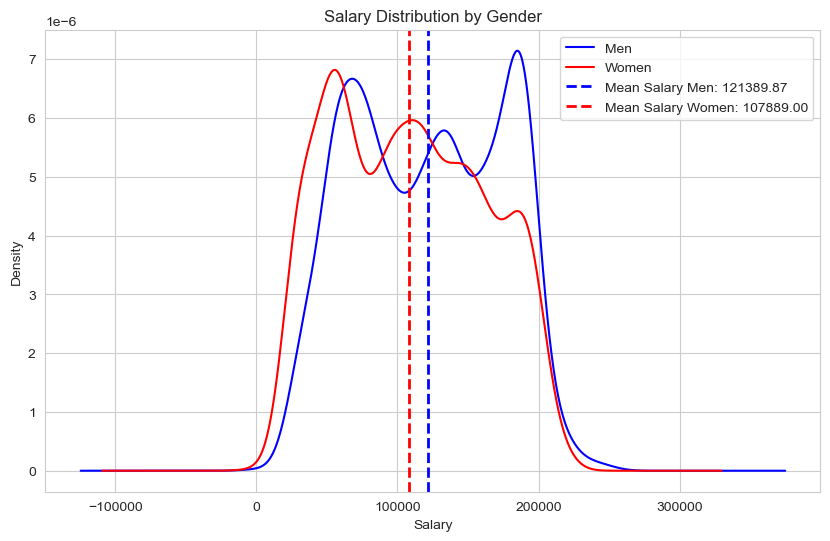

In [ ]:
df = df[df['Gender'] != 'Other']
df['Gender'].value_counts()

# Separate the data by gender
salaries_men = df[df['Gender'] == 'Male']['Salary']
salaries_women = df[df['Gender'] == 'Female']['Salary']

# Calculate the mean salaries
mean_salary_men = salaries_men.mean()
mean_salary_women = salaries_women.mean()

# Create the plot
plt.figure(figsize=(10, 6))
salaries_men.plot(kind='density', label='Men', color='blue')
salaries_women.plot(kind='density', label='Women', color='red')

# Add vertical lines for the mean salaries
plt.axvline(mean_salary_men, color='blue', linestyle='dashed', linewidth=2, label=f'Mean Salary Men: {mean_salary_men:.2f}')
plt.axvline(mean_salary_women, color='red', linestyle='dashed', linewidth=2, label=f'Mean Salary Women: {mean_salary_women:.2f}')

plt.title('Salary Distribution by Gender')
plt.xlabel('Salary')
plt.ylabel('Density')
plt.legend()
plt.show()

Diffrence in mean salary for all jobs

In [ ]:
mean_salary_men-mean_salary_women

13500.872242613157

Diffrence in mean salary prediction for all jobs

In [ ]:
model_all.predict(df)

2335.3434690502727

# Is Uni worth it?

In [ ]:
## The idea is to see if 4 years of experience is worth more than a Bachelor or 6 years more than a Master's or 10 years more than a PhD

#make fake data for seeing if uni is worth it


df_fake = pd.DataFrame([
    [27, "Male", "High School", "Software Engineer", 9, 1],
    [27, "Male", "Bachelor's", "Software Engineer",6 , 1],
    [27, "Male", "Master's", "Software Engineer", 4, 1],
    [27, "Male", "PhD", "Software Engineer", 2, 1]
], columns=["Age", "Gender", "Education Level", "Job Title", "Years of Experience", "Salary"])



# -----------NOT NECESSARY IF ALREADY DONE -------------
# Encode 'Education Level' for simplicity
education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df_fake['Education Level'] = df_fake['Education Level'].map(education_mapping).copy()

# Encode 'Gender'
gender_mapping = {'Male': 0, 'Female': 1}
df_fake['Gender'] = df_fake['Gender'].map(gender_mapping).copy()


# Scale 'Years of Experience', 'Age', and 'Salary' for stability
scaler = joblib.load("C:\Master\ML_theory\Github\ml_project\Salary new dataset\scaler_preds")
df_fake[['Years of Experience', "Salary", 'Age']] = scaler.transform(df_fake[['Years of Experience', "Salary", 'Age']])


X_train = torch.tensor(df_fake[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)

model_all_gen_age.load_state_dict(torch.load("C:\Master\ML_theory\Github\ml_project\Salary new dataset\model_all_gen_age.pth")) #load the model
model_all_gen_age.eval()

with torch.no_grad():
    predictions = model_all_gen_age(X_train)

print(predictions)

predictions_np = predictions.numpy()

dummy_array = np.zeros((len(predictions_np), 3))  # 3 columns for Years of Experience, Salary, Age
dummy_array[:, 0] = df_fake['Years of Experience']  # Scaled Years of Experience
dummy_array[:, 1] = predictions_np.flatten()  # Predictions (to be treated as Salary)
dummy_array[:, 2] = df_fake['Age']  # Scaled Age

# Inverse transform using the scaler
real_salaries = scaler.inverse_transform(dummy_array)[:, 1]  # Extract only the Salary column

# Print the real salaries
for i, salary in enumerate(real_salaries):
    print(f"Datapoint {i+1}: Predicted Salary = ${salary:.2f}")


tensor([[-0.3941],
        [-0.2742],
        [-0.4841],
        [ 0.0689],
        [-0.6454]])
Datapoint 1: Predicted Salary = $105530.90
Datapoint 2: Predicted Salary = $111409.96
Datapoint 3: Predicted Salary = $101112.37
Datapoint 4: Predicted Salary = $128238.07
Datapoint 5: Predicted Salary = $93202.39


In [79]:
#Other model
## The idea is to see if 4 years of experience is worth more than a Bachelor or 6 years more than a Master's or 10 years more than a PhD

#make fake data for seeing if uni is worth it


df_fake = pd.DataFrame([
    [27, "Male", "High School", "Software Engineer", 9, 1],
    [27, "Male", "Bachelor's", "Software Engineer",6 , 1],
    [27, "Male", "Master's", "Software Engineer", 4, 1],
    [27, "Male", "PhD", "Software Engineer", 2, 1]
], columns=["Age", "Gender", "Education Level", "Job Title", "Years of Experience", "Salary"])



# -----------NOT NECESSARY IF ALREADY DONE -------------
# Encode 'Education Level' for simplicity
education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df_fake['Education Level'] = df_fake['Education Level'].map(education_mapping).copy()

# Encode 'Gender'
gender_mapping = {'Male': 0, 'Female': 1}
df_fake['Gender'] = df_fake['Gender'].map(gender_mapping).copy()


# Scale 'Years of Experience', 'Age', and 'Salary' for stability
scaler = joblib.load("C:\Master\ML_theory\Github\ml_project\Salary new dataset\scaler_only_se")
df_fake[['Years of Experience', "Salary", 'Age']] = scaler.transform(df_fake[['Years of Experience', "Salary", 'Age']])


X_train = torch.tensor(df_fake[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)

model_all_gen_age.load_state_dict(torch.load("C:\Master\ML_theory\Github\ml_project\Salary new dataset\model_SE_gen_age.pth")) #load the model
model_all_gen_age.eval()

with torch.no_grad():
    predictions = model_all_gen_age(X_train)

print(predictions)

predictions_np = predictions.numpy()

dummy_array = np.zeros((len(predictions_np), 3))  # 3 columns for Years of Experience, Salary, Age
dummy_array[:, 0] = df_fake['Years of Experience']  # Scaled Years of Experience
dummy_array[:, 1] = predictions_np.flatten()  # Predictions (to be treated as Salary)
dummy_array[:, 2] = df_fake['Age']  # Scaled Age

# Inverse transform using the scaler
real_salaries = scaler.inverse_transform(dummy_array)[:, 1]  # Extract only the Salary column

# Print the real salaries
for i, salary in enumerate(real_salaries):
    print(f"Datapoint {i+1}: Predicted Salary = ${salary:.2f}")


tensor([[ 3.1476],
        [ 2.0182],
        [ 0.0194],
        [-1.1311]])
Datapoint 1: Predicted Salary = $262783.87
Datapoint 2: Predicted Salary = $208576.27
Datapoint 3: Predicted Salary = $112645.80
Datapoint 4: Predicted Salary = $57426.87
